In [1]:
import numpy as np
import os
import pathlib
import random
import torch
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


2023-07-03 09:18:22.805694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aman/opt/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

learnable_robot_model.make_link_param_learnable(
    "FR_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
)
learnable_robot_model.make_link_param_learnable(
        "FR_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )

# learnable_robot_model.print_learnable_params()
joint_angles = torch.rand((1, 12), requires_grad=True).to(device)
learnable_robot_model.compute_forward_kinematics(joint_angles,"FR_foot")

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

(tensor([[ 0.062,  0.145, -0.043]], grad_fn=<AddBackward0>),
 tensor([[0.315, 0.360, 0.131, 0.868]], grad_fn=<CopySlices>))

In [4]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")
training_keypoints = ['FL_Ankle','FL_Knee','BL_Ankle','BL_Knee']
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
img_path = base_dir / "HorseInferenceFiles/img0088.png"
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
image = cv2.imread(str(img_path))
dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
pose = dlc_live.init_inference(image)
# X,Y coords of selected keypoints
training_data = pose[indices_keypoints_training][:,0:2]
training_data

2023-07-03 09:18:33.175172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 09:18:33.211072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


array([[275.79907, 244.88426],
       [249.62645, 216.09793],
       [340.4294 , 246.94559],
       [349.00183, 210.68068]], dtype=float32)

In [5]:
#Initialize this Section's Data
init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
joint_angles = init_angles
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]

intrinsic = torch.Tensor([[1.0,0.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,1.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,1.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,0.0,1.0]])
extrinsic = torch.randn((1,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

#Get Robot Projection
robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
#Prune Rotation Information 
robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
robotEEPositions

{'base': tensor([[0., 0., 0.]]),
 'trunk': tensor([[0., 0., 0.]]),
 'imu_link': tensor([[0., 0., 0.]]),
 'FR_hip': tensor([[0.308, 0.000, 0.000]], grad_fn=<AddBackward0>),
 'FR_thigh_shoulder': tensor([[ 0.308, -0.143, -0.052]], grad_fn=<AddBackward0>),
 'FR_thigh': tensor([[ 0.248,  0.148, -0.194]], grad_fn=<AddBackward0>),
 'FR_calf': tensor([[0.395, 0.138, 0.112]], grad_fn=<AddBackward0>),
 'FR_foot': tensor([[ 0.330,  0.229, -0.221]], grad_fn=<AddBackward0>),
 'FL_hip': tensor([[0.025, 0.000, 0.075]], grad_fn=<AddBackward0>),
 'FL_thigh_shoulder': tensor([[0.025, 0.141, 0.129]], grad_fn=<AddBackward0>),
 'FL_thigh': tensor([[ 0.316,  0.112, -0.043]], grad_fn=<AddBackward0>),
 'FL_calf': tensor([[0.274, 0.332, 0.373]], grad_fn=<AddBackward0>),
 'FL_foot': tensor([[0.311, 0.463, 0.027]], grad_fn=<AddBackward0>),
 'RR_hip': tensor([[0.104, 0.000, 0.038]], grad_fn=<AddBackward0>),
 'RR_thigh_shoulder': tensor([[ 0.104, -0.156,  0.009]], grad_fn=<AddBackward0>),
 'RR_thigh': tensor([[ 0

In [6]:
#Calculate Training Loss
robot_joints_for_training = ["FL_foot", "FL_calf","RR_foot","RR_calf"]
jointPosition = torch.cat([robotEEPositions[joint] for joint in robot_joints_for_training])
#Reshaped to conform to be Bx1x#Jointsx3 for use with cam2pixel
reshapedJointPosition = jointPosition.reshape((1,1,-1,3))
jointCameraPositions = torchgeometry.cam2pixel(reshapedJointPosition, intrinsic @ extrinsic)
loss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions - torch.from_numpy(training_data), 2),-1)))

<Figure size 640x480 with 0 Axes>

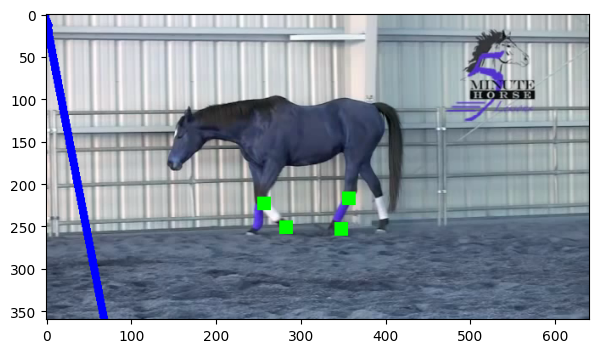

In [7]:
img = image.copy()
allJointPosiitons = torchgeometry.cam2pixel(torch.cat(tuple(robotEEPositions.values())).reshape((1,1,-1,3)), intrinsic@extrinsic).reshape((-1,2))
jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
size = 15
#Draw Robot Joints
for jointPositionTensor in jointToCameraPosition.values():
    jointPosition = jointToCameraPosition["base"].detach().numpy()
    x,y = tuple((int(i) for i in jointPosition))
    img = cv2.circle(img,(x, y),size//2,(255,255,0))
for line in links:
    start,end = line[0], line[1]
    start, end = jointToCameraPosition[start], jointToCameraPosition[end]
    start = tuple(start.detach().numpy())
    end = tuple(end.detach().numpy())
    start = tuple((int(i) for i in start))
    end = tuple((int(i) for i in end))
    img = cv2.line(img,start, end, (0,0,255),size//2)
#Draw Keypoints
for x,y in training_data:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
plt.clf()
plt.figure(figsize=(7,5))
plt.imshow(img)
plt.show()

## Training Loop

In [9]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]
robot_joints_for_training = ["FL_foot", "FL_calf","RR_foot","RR_calf"]


init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
joint_angles = init_angles

intrinsic = torch.Tensor([[1.0,0.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,1.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,1.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,0.0,1.0]])
extrinsic = torch.randn((1,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

%matplotlib inline
VERBOSE = False

optimizer = torch.optim.Adam([joint_angles,intrinsic, extrinsic] + list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
for epoch in range(2000000):
    optimizer.zero_grad()
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    jointPosition = torch.cat([robotEEPositions[joint] for joint in robot_joints_for_training])
    reshapedJointPosition = jointPosition.reshape((1,1,-1,3))
    jointCameraPositions = torchgeometry.cam2pixel(reshapedJointPosition, intrinsic @ extrinsic)
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions - torch.from_numpy(training_data), 2),-1)))



    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
    n = 1000
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
        img = image.copy()
        allJointPosiitons = torchgeometry.cam2pixel(torch.cat(tuple(robotEEPositions.values())).reshape((1,1,-1,3)), intrinsic@extrinsic).reshape((-1,2))
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Joints
        for jointPositionTensor in jointToCameraPosition.values():
            jointPosition = jointToCameraPosition["base"].copy().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),size//2,(255,255,0))
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.copy().detach().numpy())
            end = tuple(end.copy().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//2)
        #Draw Keypoints
        for x,y in training_data:
                    color = (0,255,0)
                    img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        plt.clf()
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()


Starting Training


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [13]:
def getRobotPositionsFromJointAngles(joint_angles_array, learnable_robot_model):
    """
        Takes in joint angles array and the robot model. Outputs the 3d position of selected joints of the robot given the joint angles.
        Supports batches of joint angles.
    """
    projections = []
    #Where the Robot Thinks It Is
    for joint_angles in joint_angles_array:
        projection = torch.cat((learnable_robot_model.compute_forward_kinematics(joint_angles, "FL_foot")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "FL_calf")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "RR_foot")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "RR_calf")[0]))
        projection = projection.unsqueeze(0).unsqueeze(0)
        projections.append(projection)
    return torch.cat(projections)

def getRobotPositionsInPixelSpace(conversionMatrix, robotPositions):
    """
        Takes in robot positions in 3D space relative to the robot. Then uses the conversion Matrix to figure out where the robot is in the pixel space of the camera. Supports batches of robotPositions.
    """
    return torchgeometry.cam2pixel(robotPositions, conversionMatrix)

def getRobotPositionInCamera(joint_angles_array, conversionMatrix, learnable_robot_model):
    return getRobotPositionsInPixelSpace(conversionMatrix, getRobotPositionsFromJointAngles(joint_angles_array, learnable_robot_model))

In [14]:
links = learnable_robot_model.get_link_names()

Starting Training
Epoch 0: Loss (3122.177734375)


<Figure size 640x480 with 0 Axes>

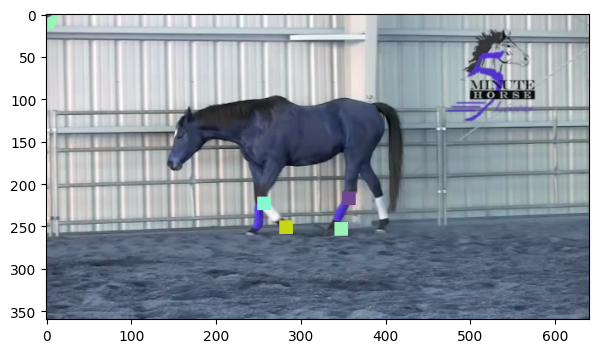

KeyboardInterrupt: 

In [15]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]
init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
endeffector_positions = learnable_robot_model.compute_forward_kinematics_all_links(init_angles)
#Only keep the position tensor and then remove the batch dimension from it
endeffector_positions = {keypointName: endeffector_positions[keypointName][0].squeeze(0) for keypointName in endeffector_positions}
endeffectorList = learnable_robot_model.get_link_names()


intrinsic = torch.Tensor([[1.0,0.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,1.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,1.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,0.0,1.0]])
extrinsic = torch.randn((batch_size,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

%matplotlib inline
VERBOSE = False

optimizer = torch.optim.Adam([joint_angles_array,intrinsic, extrinsic] + list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
for epoch in range(2000000):
    optimizer.zero_grad()
    conversionMatrix = intrinsic @ extrinsic
    cameraEstimate = getRobotPositionInCamera(joint_angles_array, conversionMatrix, learnable_robot_model)
    debugPrint(f"Camera Estimate Shape: {cameraEstimate.shape}")
    
    #Loss Between Where Robot/Horse Should Be and Where It Is
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow((training_data)-cameraEstimate, 2))))


    
    

    if VERBOSE:
        print(f"Epoch {epoch}: Loss ({loss})")
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss ({loss})")

        imgIndex = 0
        img = images[imgIndex].copy()
        random.seed(0)
        size = 15
        for x,y in training_data[imgIndex]:
            color = (randrange(0,256),randrange(0,256),randrange(0,256))
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        random.seed(0)
        for x,y in cameraEstimate[imgIndex][0]:
            color = (randrange(0,256),randrange(0,256),randrange(0,256))
            img = cv2.circle(img, (int(x), int(y)), size, color, -1)

        plt.clf()
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()


In [40]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]
init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
endeffector_positions = learnable_robot_model.compute_forward_kinematics_all_links(init_angles)
#Only keep the position tensor and then remove the batch dimension from it
endeffector_positions = {keypointName: endeffector_positions[keypointName][0].squeeze(0) for keypointName in endeffector_positions}
endeffectorList = learnable_robot_model.get_link_names()

In [57]:
x = torch.randn(1, 3)
a = torch.cat((x,x),0).unsqueeze(0)
torch.cat((a,a,a,a),0).shape

torch.Size([4, 2, 3])

In [41]:
torch.tensor([(endeffectorList.index(l[0]), endeffectorList.index(l[1])) for l in links]).map

tensor([[ 0,  1],
        [ 1,  2],
        [ 1,  3],
        [ 3,  4],
        [ 3,  5],
        [ 5,  6],
        [ 6,  7],
        [ 1,  8],
        [ 8,  9],
        [ 8, 10],
        [10, 11],
        [11, 12],
        [ 1, 13],
        [13, 14],
        [13, 15],
        [15, 16],
        [16, 17],
        [ 1, 18],
        [18, 19],
        [18, 20],
        [20, 21],
        [21, 22]])

TODO:
✓ Init Joint Angles to middle of upper and lower limit.
✓ Rotation google decomposition to rotation/translation for implementation. Idea for simple POC is identity matrix for first 3 columns, then 4th column xyz randomized with z > 0, and xy around 0.
    ✓Extrinsic changes with batch
    ✓Intrinsice stays the same
Plot the entire robot skeleton
Remaking code to only go 1 image at a time for now
Add in tests for submodules
